### Imports

In [2]:
import tclab
from tclab import Plotter, clock, Historian

import numpy as np
import tbcontrol
from tbcontrol import blocksim

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
%matplotlib inline

### Choosing FOPDT Average

In [4]:
fopdt_data = np.array([
    [0.7341360491863929, 5.210123907977371, 16.559014472419413, 59.523529460492334],
    [0.6774381067692021, 5.00318530935408, 21.880950702722618, 62.53818192956931],
    [0.5918406173295354, 5.040559078180837, 13.000100995585509, 56.573240300896146],
    [0.6587642439039652, 5.125181352181385, 11.311544977550096, 60.70999990554319],
    [0.665168891367717, 5.08636176827353, 24.000324775225323, 54.7982710939057],
    [0.6387911785228116, 4.948465387790217, 22.256208149276805, 53.376521840162795],
    [0.6292754662892898, 5.034289775309076, 15.937080631929664, 56.03874984767521] ,
    [0.6373484264704146, 5.03641510581949, 18.059160697072777, 62.09263157538431] ,
    [0.6713988296146404, 5.001927203463662, 21.991782963030236, 54.415000100624546],
    [0.6414681930776353, 4.67049348629001, 16.454289186711623, 58.92117677804579],
    [0.6346096151258821, 5.244619478026639, 20.1046046449354, 59.56476177014588] ,
    [0.5630439772902066, 4.720256665814206, 11.001116186034224, 58.34544676857376],
    [0.6364559283996897, 5.057530141948191, 14.34007107049632, 59.580000064404636],
    [0.6127093093146742, 4.998589401569082, 16.661653475453175, 52.7164705919754]
])

Kp = np.average(fopdt_data[:,0])
τp = np.exp(np.average(fopdt_data[:,1]))
θp = np.average(fopdt_data[:,2])
To_p = np.average(fopdt_data[:,3])

In [5]:
Kp, τp, θp, To_p

(0.6423177737615754, 150.3121523254063, 17.396993066317368, 57.79957014481422)

### Defining functions and blocksim blocks

In [6]:
#P controller

def cohen_coon(controller_type, parameters):
    Kp, τ, θ =  parameters
    
    if controller_type == 'P':
        Kc = (1.03/Kp)*(τ/θ + 0.34)
        return Kc

#PI controller
    if controller_type == 'PI':
        Kc = (0.9/Kp)*(τ/θ + 0.092)
        τI = (3.33*θ)*((τ + 0.092*θ)/(τ + 2.22*θ))
        return Kc, τI


#PD controller
    if controller_type == 'PD':
        Kc = (1.24/Kp)*(τ/θ + 0.129)
        τd = 0.27*θ*((τ - 0.324*θ)/(τ + 0.129*θ))
        α = 2
        return Kc, τd, α

#PID controller
    if controller_type == 'PID':
        Kc = (1.35/Kp)*(τ/θ + 0.185)
        τI = 2.5*θ*((τ + 0.185*θ)/(τ + 0.611*θ))
        τd = 0.37*θ*(τ/(τ + 0.185*θ))
        return Kc, τI, τd
    


In [7]:
def controller_block(controller_type, parameters):
    
    if controller_type == 'P':
        Kc_P = parameters
        Gc_P = blocksim.LTI('Gc_P', 'e', 'Q', Kc_P, 1)
        return Gc_P
    
    if controller_type == 'PI':
        Kc_PI, τI_PI = parameters
        Gc_PI = blocksim.PI('Gc_PI','e','Q', Kc_PI, τI_PI)
        return Gc_PI
    
    if controller_type == 'PD':
        Kc_PD, τD_PD, α = parameters
        Gc_PD = blocksim.LTI('Gc_PD','e','Q', [Kc_PD * τD_PD * (α + 1), Kc_PD], [τD_PD * α, 1]) 
        # Used the α term for physical realizability - Textbook eq 7-12 pg 129
        return Gc_PD
    
    if controller_type == 'PID':
        Kc_PID, τI_PID, τD_PID = parameters
        Gc_PID = blocksim.PID('Gc_PID', 'e', 'Q', Kc_PID, τI_PID, τD_PID)
        return Gc_PID

In [8]:
def system_block(Kp, τp, θp):
    Gp = blocksim.LTI('Gp', 'Q', 'Tp', Kp, [τp, 1], θp) # Block of the system FOPDT model
    return Gp

- The following cell contains the blocks that can be used as 'controller_block' inputs to the 'diagram' function.
- The parameters need to be changed to the correct FOPDT + Cohen-Coon parameters

In [9]:
Gp = system_block(Kp, τp, θp)

In [10]:
parameters = Kp, τp, θp

Gc_P = controller_block('P', cohen_coon('P', parameters)) # parameters = Kc_P

Gc_PI = controller_block('PI', cohen_coon('PI', parameters)) # parameters = Kc_PI, τI_PI

Gc_PD = controller_block('PD', cohen_coon('PD', parameters)) # parameters = Kc_PD, τD_PD, α

Gc_PID = controller_block('PID', cohen_coon('PID', parameters)) # parameters = Kc_PID, τI_PID, τD_PID

In [11]:
def diagram(controller_block ,system_block, setpoint, disturbance):
    Gc = controller_block
    Gp = system_block
    
    diagram = blocksim.Diagram([Gc, Gp],
                            sums = {'e': ('+Tsp', '-T'), 'T': ('+Td', '+Tp')},
                               # The disturbance will be added here also when we get there
                            inputs = {'Tsp': blocksim.step(0, 0, setpoint),
                                      'Td': blocksim.step(0, 0, disturbance)}
                            )
    return diagram

### Simulation with models

##### Setpoint Changes

In [14]:
diagram_P = diagram(Gc_P, Gp,1, 0) 
diagram_PI = diagram(Gc_PI, Gp, 1, 0)
diagram_PD = diagram(Gc_PD, Gp, 1, 0)
diagram_PID = diagram(Gc_PID, Gp, 1, 0)

In [15]:
ts = np.linspace(0, 500, 5000)

In [16]:
simulation_P = diagram_P.simulate(ts, progress = True)
simulation_PI = diagram_PI.simulate(ts, progress = True)
# simulation_PD = diagram_PD.simulate(ts, progress = True)
simulation_PID = diagram_PID.simulate(ts, progress = True)

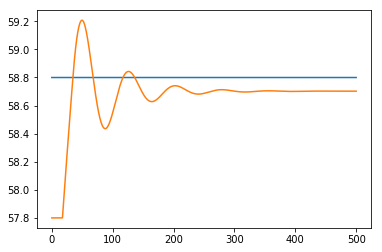

In [17]:
plt.figure(1)
plt.plot(list(ts), [T+To_p for T in simulation_P['Tsp']])
plt.plot(list(ts), [T+To_p for T in simulation_P['T']])
plt.show()

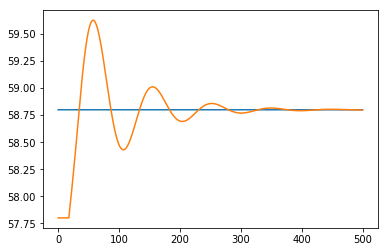

In [18]:
plt.figure(2)
plt.plot(list(ts), [T+To_p for T in simulation_PI['Tsp']])
plt.plot(list(ts), [T+To_p for T in simulation_PI['T']])
plt.show()

In [19]:
# plt.figure(3)
# plt.plot(list(ts), [T+To_p for T in simulation_PD['Tsp']])
# plt.plot(list(ts), [T+To_p for T in simulation_PD['T']])
# plt.show()

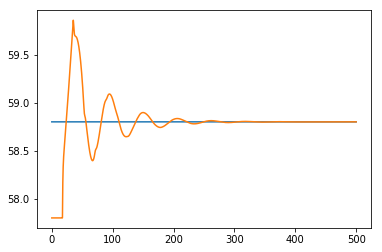

In [20]:
plt.figure(4)
plt.plot(list(ts), [T+To_p for T in simulation_PID['Tsp']])
plt.plot(list(ts), [T+To_p for T in simulation_PID['T']])
plt.show()

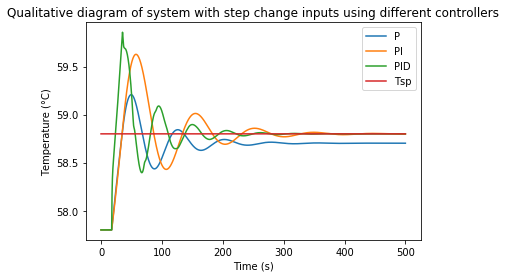

In [21]:
plt.figure(5)
plt.plot(list(ts), [T+To_p for T in simulation_P['T']], label='P')
plt.plot(list(ts), [T+To_p for T in simulation_PI['T']], label ='PI')
# plt.plot(list(ts), [T+To_p for T in simulation_PD['T']], label ='PD')
plt.plot(list(ts), [T+To_p for T in simulation_PID['T']], label ='PID')
plt.plot(list(ts), [T+To_p for T in simulation_PID['Tsp']], label ='Tsp')
plt.title("Qualitative diagram of system with step change inputs using different controllers")
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

##### Disturbance changes

In [25]:
diagram_P = diagram(Gc_P, Gp, 0, 1) 
diagram_PI = diagram(Gc_PI, Gp, 0, 1)
diagram_PD = diagram(Gc_PD, Gp, 0, 1)
diagram_PID = diagram(Gc_PID, Gp, 0, 1)

In [26]:
ts = np.linspace(0, 500, 5000)

In [27]:
simulation_P_d = diagram_P.simulate(ts, progress = True)
simulation_PI_d = diagram_PI.simulate(ts, progress = True)
# simulation_PD = diagram_PD.simulate(ts, progress = True)
simulation_PID_d = diagram_PID.simulate(ts, progress = True)

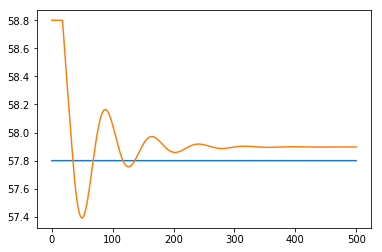

In [28]:
plt.figure(6)
plt.plot(list(ts), [T+To_p for T in simulation_P_d['Tsp']])
plt.plot(list(ts), [T+To_p for T in simulation_P_d['T']])
plt.show()

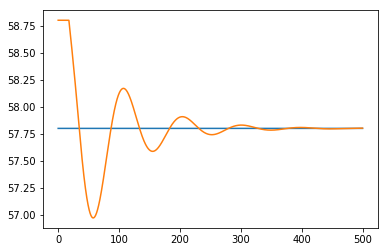

In [29]:
plt.figure(7)
plt.plot(list(ts), [T+To_p for T in simulation_PI_d['Tsp']])
plt.plot(list(ts), [T+To_p for T in simulation_PI_d['T']])
plt.show()

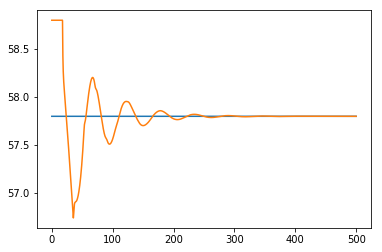

In [30]:
plt.figure(8)
plt.plot(list(ts), [T+To_p for T in simulation_PID_d['Tsp']])
plt.plot(list(ts), [T+To_p for T in simulation_PID_d['T']])
plt.show()

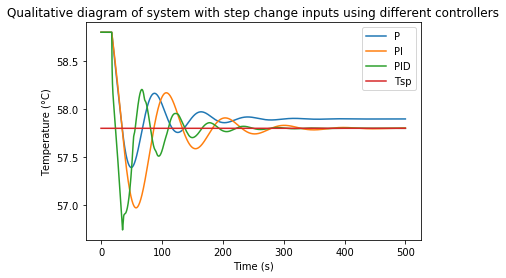

In [31]:
plt.figure(9)
plt.plot(list(ts), [T+To_p for T in simulation_P_d['T']], label='P')
plt.plot(list(ts), [T+To_p for T in simulation_PI_d['T']], label ='PI')
# plt.plot(list(ts), [T+To_p for T in simulation_PD['T']], label ='PD')
plt.plot(list(ts), [T+To_p for T in simulation_PID_d['T']], label ='PID')
plt.plot(list(ts), [T+To_p for T in simulation_PID_d['Tsp']], label ='Tsp')
plt.title("Qualitative diagram of system with step change inputs using different controllers")
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

### Running controllers with the TCLab

##### PID

In [ ]:
TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
               ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 1200)
    
    for t in clock(1200):
        if t < 300:
            T1sp = 20
        else:
            T1sp = 50
            
        Q1 = lab.Q1(Gc_PID.output)
        T1 = lab.T1
        e = T1sp - T1
        Gc_PID.change_input(t, e)
        Gc_PID.change_state(Gc_PID.state + Gc_PID.derivative(e))
        
        h.update(t) 
        p.update(t)

In [ ]:
Gc_PID.output

##### PI

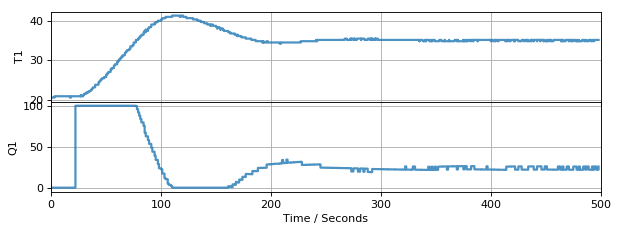

TCLab Model disconnected successfully.


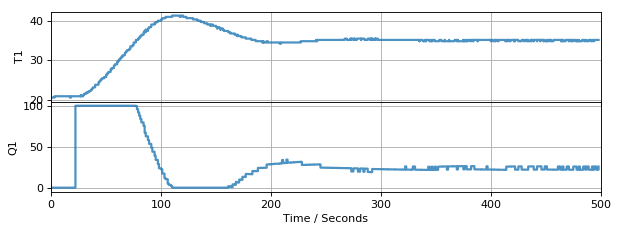

In [350]:
TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for t in clock(500):
        if t < 20:
            T1sp = 20
        else:
            T1sp = 35
        Q1 = lab.Q1(Gc_PI.output)
        T1 = lab.T1
        e = T1sp-T1
        Gc_PI.change_input(t,e)
        Gc_PI.change_state(Gc_PI.state+Gc_PI.derivative(e))
        
        
        h.update(t) 
        p.update(t)

##### P

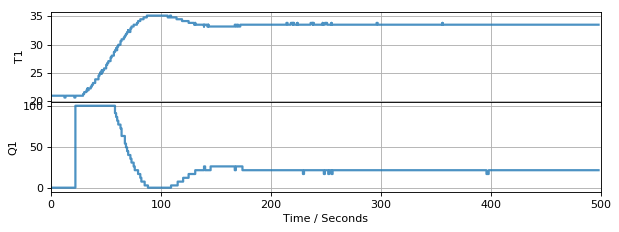

TCLab Model disconnected successfully.


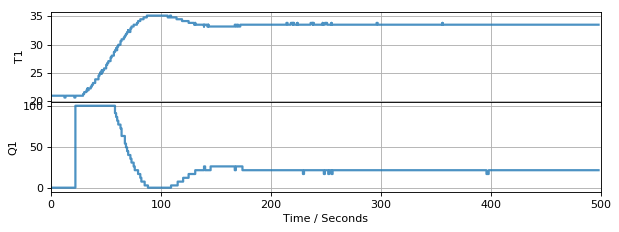

In [353]:
TCLab = tclab.setup(connected=False, speedup=10)


with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for t in clock(500):
        if t < 20:
            T1sp = 20
        else:
            T1sp = 35
        Q1 = lab.Q1(Gc_P.output)
        T1 = lab.T1
        e = T1sp-T1
        Gc_P.change_input(t,e)
        Gc_P.change_state(Gc_P.state + Gc_P.derivative(e))
        
        
        h.update(t) 
        p.update(t)

# IAE Controller

# Setpoint changes

In [12]:
def IAE_setpoints(controller_type, parameters):
    Kp, τ, θ = parameters
#setpoints
    if controller_type == 'PI':   
        # PI
        Kc = (0.758/Kp)*(θ/τ)**-0.861
        τI = τ/(1.02 - 0.323*(θ/τ))
        return Kc, τI


    if controller_type == 'PID':
        # PID
        Kc = (1.086/Kp)*(θ/τ)**-0.869
        τI = τ/(0.740 - 0.130*(θ/τ))
        τd = 0.348*τ*(θ/τ)**0.914
        return Kc, τI, τd

In [13]:
parameters = Kp, τp, θp


Gc_PI_IAES = controller_block('PI', IAE_setpoints('PI', parameters)) # parameters = Kc_PI, τI_PI

Gc_PID_IAES = controller_block('PID', IAE_setpoints('PID', parameters)) # parameters = Kc_PID, τI_PID, τD_PID

In [14]:
diagram_PI_IAES = diagram(Gc_PI_IAES, Gp, 1, 0)
diagram_PID_IAES = diagram(Gc_PID_IAES, Gp, 1, 0)

In [15]:
ts = np.linspace(0, 500, 5000)

In [16]:
simulation_PI_IAES = diagram_PI_IAES.simulate(ts, progress = True)
simulation_PID_IAES = diagram_PID_IAES.simulate(ts, progress = True)

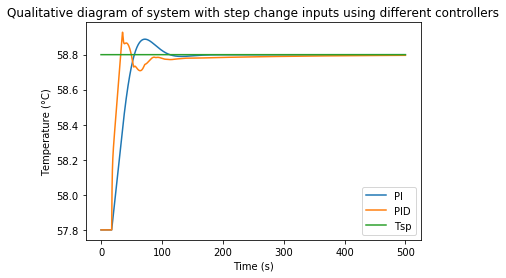

In [17]:
plt.figure(10)
plt.plot(list(ts), [T+To_p for T in simulation_PI_IAES['T']], label='PI')
plt.plot(list(ts), [T+To_p for T in simulation_PID_IAES['T']], label ='PID')
plt.plot(list(ts), [T+To_p for T in simulation_PID_IAES['Tsp']], label ='Tsp')
plt.title("Qualitative diagram of system with step change inputs using different controllers")
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

### Running controllers with the TCLab for setpoint changes

## PI

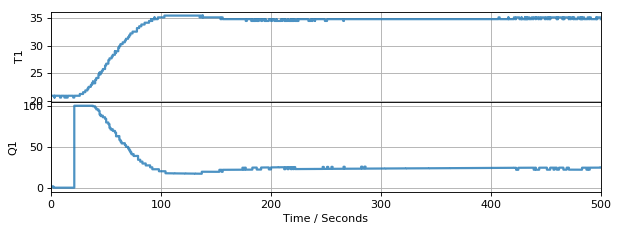

TCLab Model disconnected successfully.


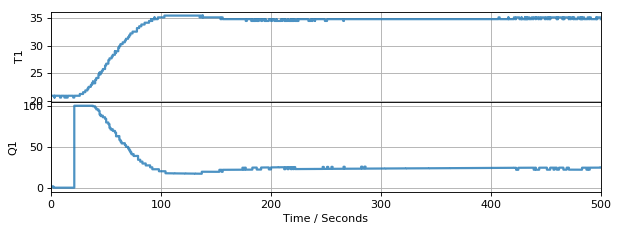

In [33]:
TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for t in clock(500):
        if t < 20:
            T1sp = 20
        else:
            T1sp = 35
        Q1 = lab.Q1(Gc_PI_IAES.output)
        T1 = lab.T1
        e = T1sp-T1
        Gc_PI_IAES.change_input(t,e)
        Gc_PI_IAES.change_state(Gc_PI_IAES.state+Gc_PI_IAES.derivative(e))
        
        
        h.update(t) 
        p.update(t)

## PID

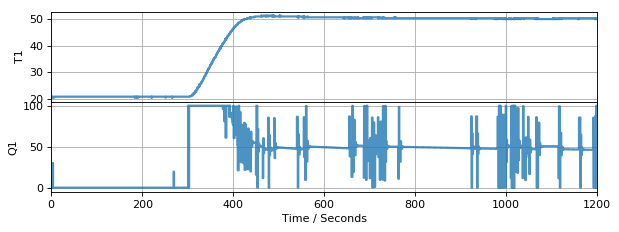

TCLab Model disconnected successfully.


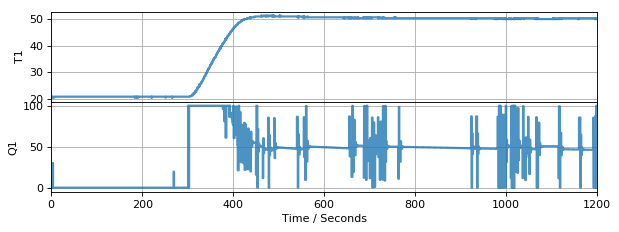

In [40]:
TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
               ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 1200)
    
    for t in clock(1200):
        if t < 300:
            T1sp = 20
        else:
            T1sp = 50
            
        Q1 = lab.Q1(Gc_PID_IAES.output)
        T1 = lab.T1
        e = T1sp - T1
        Gc_PID_IAES.change_input(t, e)
        Gc_PID_IAES.change_state(Gc_PID_IAES.state + Gc_PID_IAES.derivative(e))
        
        h.update(t) 
        p.update(t)

# Disturbances

In [18]:
def IAE_disturbances(controller_type, parameters):
    Kp, τ , θ = parameters
#disturbance
    if controller_type == 'P':
        # P
        Kc = (0.902/Kp)*(θ/τ)**-0.985
        return Kc
    
    if controller_type == 'PI':
        # PI
        Kc = (0.984/Kp)*(θ/τ)**-0.986
        τI = (τ/0.608)*(θ/τ)**0.707
        return Kc, τI

    if controller_type == 'PID':
        # PID
        Kc = (1.435/Kp)*(θ/τ)**-0.921
        τI = (τ/0.878)*(θ/τ)**0.749
        τd = 0.482*τ*(θ/τ)**1.137
        return Kc, τI, τd


In [19]:
parameters = Kp, τp, θp

Gc_P_IAED = controller_block('P', IAE_disturbances('P', parameters)) # parameters = Kc_P

Gc_PI_IAED = controller_block('PI', IAE_disturbances('PI', parameters)) # parameters = Kc_PI, τI_PI

Gc_PID_IAED = controller_block('PID', IAE_disturbances('PID', parameters)) # parameters = Kc_PID, τI_PID, τD_PID

In [20]:
diagram_P_IAED = diagram(Gc_P_IAED, Gp, 0, 1) 
diagram_PI_IAED = diagram(Gc_PI_IAED, Gp, 0, 1)
diagram_PID_IAED = diagram(Gc_PID_IAED, Gp, 0, 1)

In [21]:
ts = np.linspace(0, 500, 5000)

In [22]:
simulation_P_IAED = diagram_P_IAED.simulate(ts, progress = True)
simulation_PI_IAED = diagram_PI_IAED.simulate(ts, progress = True)
simulation_PID_IAED = diagram_PID_IAED.simulate(ts, progress = True)

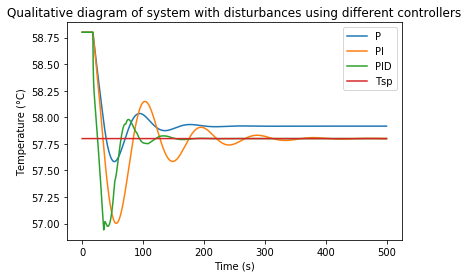

In [23]:
plt.figure(11)
plt.plot(list(ts), [T+To_p for T in simulation_P_IAED['T']], label='P')
plt.plot(list(ts), [T+To_p for T in simulation_PI_IAED['T']], label ='PI')
# plt.plot(list(ts), [T+To_p for T in simulation_PD['T']], label ='PD')
plt.plot(list(ts), [T+To_p for T in simulation_PID_IAED['T']], label ='PID')
plt.plot(list(ts), [T+To_p for T in simulation_PID_IAED['Tsp']], label ='Tsp')
plt.title("Qualitative diagram of system with disturbances using different controllers")
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

### Running controllers with the TCLab for disturbances

## P

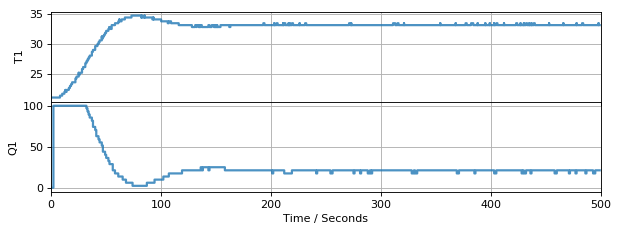

TCLab Model disconnected successfully.


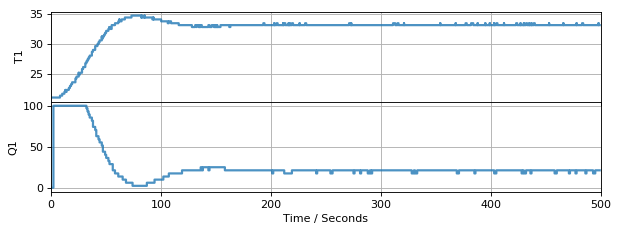

In [24]:
TCLab = tclab.setup(connected=False, speedup=10)


with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for t in clock(500):
        T1sp = 35
        Q1 = lab.Q1(Gc_P_IAED.output)
        T1 = lab.T1
        e = T1sp-T1
        Gc_P_IAED.change_input(t,e)
        Gc_P_IAED.change_state(Gc_P_IAED.state + Gc_P_IAED.derivative(e))
        
        
        h.update(t) 
        p.update(t)

## PI

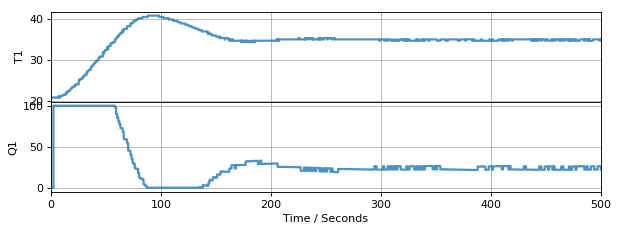

TCLab Model disconnected successfully.


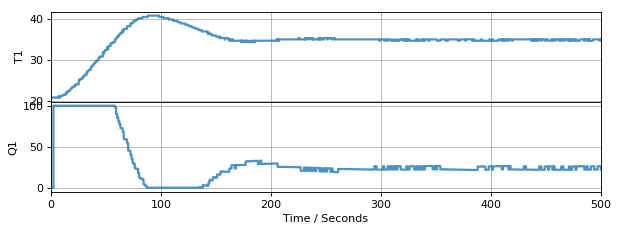

In [25]:
TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for t in clock(500):
        T1sp = 35
        Q1 = lab.Q1(Gc_PI_IAED.output)
        T1 = lab.T1
        e = T1sp - T1
        Gc_PI_IAED.change_input(t,e)
        Gc_PI_IAED.change_state(Gc_PI_IAED.state + Gc_PI_IAED.derivative(e))
        
        
        h.update(t) 
        p.update(t)

## PID

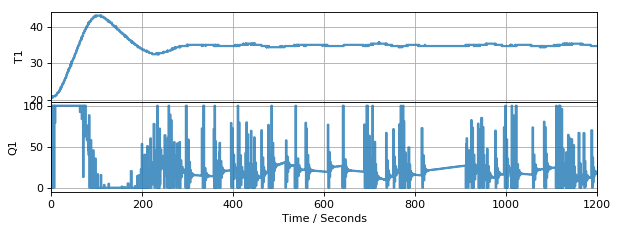

TCLab Model disconnected successfully.


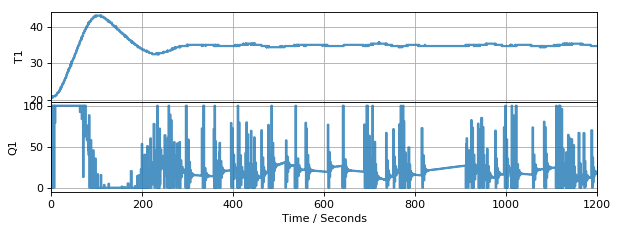

In [26]:
TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
               ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 1200)
    
    for t in clock(1200):
        T1sp = 35 
        Q1 = lab.Q1(Gc_PID_IAED.output)
        T1 = lab.T1
        e = T1sp - T1
        Gc_PID_IAED.change_input(t, e)
        Gc_PID_IAED.change_state(Gc_PID_IAED.state + Gc_PID_IAED.derivative(e))
        
        h.update(t) 
        p.update(t)

## System Noise

In [38]:
def Noise(size):  
    def stepfunction(t): # Need a second function to be f(t) wrapped inside the first
            return np.random.randn()*size
    return stepfunction

In [39]:
def diagram_with_noise(controller_block ,system_block, setpoint, disturbance, noise_size):
    Gc = controller_block
    Gp = system_block
    
    diagram = blocksim.Diagram([Gc, Gp],
                            sums = {'e': ('+Tsp', '-T'), 'T': ('+Td', '+Tp', '+Tn')},
                               # The disturbance will be added here also when we get there
                            inputs = {'Tsp': blocksim.step(0, 0, setpoint),
                                      'Td': blocksim.step(0, 0, disturbance),
                                      'Tn': Noise(noise_size)}
                            )
    return diagram

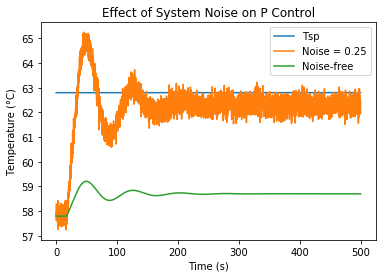

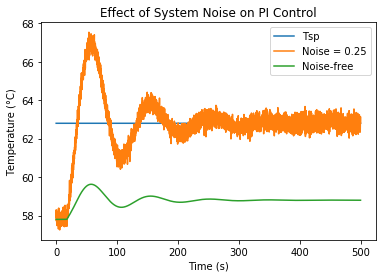

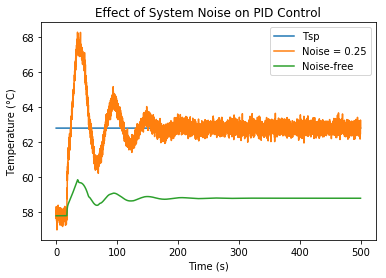

In [41]:
noise_diagram_P   = diagram_with_noise(Gc_P  , Gp, 5, 0, 0.25) 
noise_diagram_PI  = diagram_with_noise(Gc_PI , Gp, 5, 0, 0.25)
noise_diagram_PID = diagram_with_noise(Gc_PID, Gp, 5, 0, 0.25)

ts = np.linspace(0, 500, 5000)

noise_simulation_P   = noise_diagram_P.simulate(ts, progress = True)
noise_simulation_PI  = noise_diagram_PI.simulate(ts, progress = True)
noise_simulation_PID = noise_diagram_PID.simulate(ts, progress = True)

plt.figure(1)
plt.plot(list(ts), [T+To_p for T in noise_simulation_P['Tsp']], label='Tsp')
plt.plot(list(ts), [T+To_p for T in noise_simulation_P['T']], label='Noise = 0.25')
plt.plot(list(ts), [T+To_p for T in simulation_P['T']], label='Noise-free')
plt.title('Effect of System Noise on P Control')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(list(ts), [T+To_p for T in noise_simulation_PI['Tsp']], label='Tsp')
plt.plot(list(ts), [T+To_p for T in noise_simulation_PI['T']], label='Noise = 0.25')
plt.plot(list(ts), [T+To_p for T in simulation_PI['T']], label='Noise-free')
plt.title('Effect of System Noise on PI Control')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

plt.figure(3)
plt.plot(list(ts), [T+To_p for T in noise_simulation_PID['Tsp']], label='Tsp')
plt.plot(list(ts), [T+To_p for T in noise_simulation_PID['T']], label='Noise = 0.25')
plt.plot(list(ts), [T+To_p for T in simulation_PID['T']], label='Noise-free')
plt.title('Effect of System Noise on PID Control')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

##### Disturbance changes

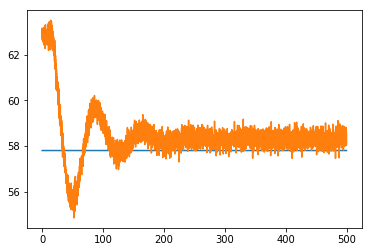

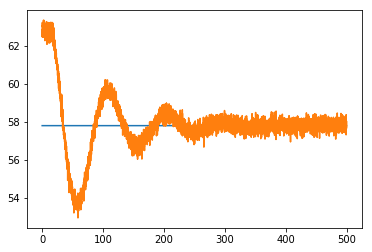

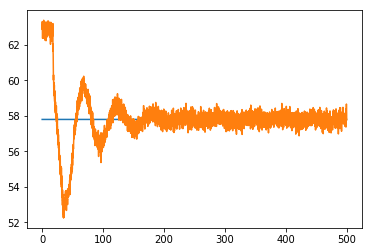

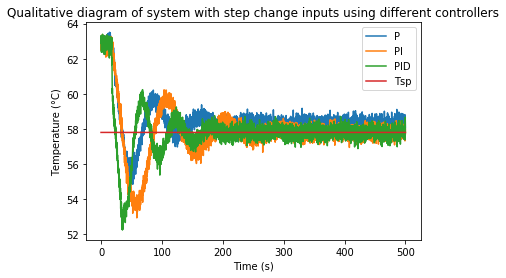

In [42]:
noise_diagram_P   = diagram_with_noise(Gc_P  , Gp, 0, 5, 0.25) 
noise_diagram_PI  = diagram_with_noise(Gc_PI , Gp, 0, 5, 0.25)
noise_diagram_PD  = diagram_with_noise(Gc_PD , Gp, 0, 5, 0.25)
noise_diagram_PID = diagram_with_noise(Gc_PID, Gp, 0, 5, 0.25)

ts = np.linspace(0, 500, 5000)

noise_simulation_P_d   = noise_diagram_P.simulate(ts, progress = True)
noise_simulation_PI_d  = noise_diagram_PI.simulate(ts, progress = True)
#noise_simulation_PD  = noise_diagram_PD.simulate(ts, progress = True)
noise_simulation_PID_d = noise_diagram_PID.simulate(ts, progress = True)

plt.figure(6)
plt.plot(list(ts), [T+To_p for T in noise_simulation_P_d['Tsp']])
plt.plot(list(ts), [T+To_p for T in noise_simulation_P_d['T']])
plt.show()

plt.figure(7)
plt.plot(list(ts), [T+To_p for T in noise_simulation_PI_d['Tsp']])
plt.plot(list(ts), [T+To_p for T in noise_simulation_PI_d['T']])
plt.show()

plt.figure(8)
plt.plot(list(ts), [T+To_p for T in noise_simulation_PID_d['Tsp']])
plt.plot(list(ts), [T+To_p for T in noise_simulation_PID_d['T']])
plt.show()

plt.figure(9)
plt.plot(list(ts), [T+To_p for T in noise_simulation_P_d['T']], label='P')
plt.plot(list(ts), [T+To_p for T in noise_simulation_PI_d['T']], label ='PI')
# plt.plot(list(ts), [T+To_p for T in simulation_PD['T']], label ='PD')
plt.plot(list(ts), [T+To_p for T in noise_simulation_PID_d['T']], label ='PID')
plt.plot(list(ts), [T+To_p for T in noise_simulation_PID_d['Tsp']], label ='Tsp')
plt.title("Qualitative diagram of system with step change inputs using different controllers")
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()